# Week 07 — Neural Networks From Scratch

This notebook implements neural networks from first principles to deeply understand forward/backprop. You'll:
- Build a fully connected neural network in NumPy
- Implement backpropagation manually
- Perform gradient checking
- Experiment with initializations and activations

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_classification
from sklearn.model_selection import train_test_split
%matplotlib inline

np.random.seed(42)
print("Libraries imported!")

Libraries imported!


In [2]:

import os, pickle

CACHE_DIR = "cache_week07"
os.makedirs(CACHE_DIR, exist_ok=True)

def save_result(key, obj):
    with open(os.path.join(CACHE_DIR, f"{key}.pkl"), "wb") as f:
        pickle.dump(obj, f)

def load_result(key):
    path = os.path.join(CACHE_DIR, f"{key}.pkl")
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    return None

def cached(key, compute_fn):
    result = load_result(key)
    if result is not None:
        print(f"[cache] loaded '{key}'")
        return result
    print(f"[cache] computing '{key}'...")
    result = compute_fn()
    save_result(key, result)
    return result

print("Cache utilities ready. Results will be stored in:", CACHE_DIR)


Cache utilities ready. Results will be stored in: cache_week07


## 1. Build a Fully Connected Neural Network

Implement forward pass, loss, backward pass, and training loop from scratch.

In [3]:
# Activation functions
def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def sigmoid_grad(x):
    s = sigmoid(x)
    return s * (1 - s)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Simple 2-layer neural network
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, init_std=0.01):
        """Initialize network parameters"""
        self.W1 = np.random.randn(input_size, hidden_size) * init_std
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * init_std
        self.b2 = np.zeros((1, output_size))
        
        # Cache for backprop
        self.cache = {}
    
    def forward(self, X):
        """Forward pass"""
        # Layer 1
        z1 = X @ self.W1 + self.b1
        a1 = relu(z1)
        
        # Layer 2
        z2 = a1 @ self.W2 + self.b2
        a2 = softmax(z2)
        
        # Cache for backward pass
        self.cache = {'X': X, 'z1': z1, 'a1': a1, 'z2': z2, 'a2': a2}
        return a2
    
    def backward(self, y_true):
        """Backward pass (backpropagation)"""
        m = y_true.shape[0]
        X = self.cache['X']
        a1 = self.cache['a1']
        a2 = self.cache['a2']
        z1 = self.cache['z1']
        
        # Output layer gradient
        dz2 = a2 - y_true  # Softmax + cross-entropy gradient
        dW2 = a1.T @ dz2 / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        
        # Hidden layer gradient
        da1 = dz2 @ self.W2.T
        dz1 = da1 * relu_grad(z1)
        dW1 = X.T @ dz1 / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        
        return {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    
    def compute_loss(self, y_pred, y_true):
        """Cross-entropy loss"""
        m = y_true.shape[0]
        log_probs = -np.log(y_pred[range(m), y_true.argmax(axis=1)] + 1e-8)
        return np.mean(log_probs)
    
    def train_step(self, X, y, lr=0.01):
        """One training step"""
        # Forward
        y_pred = self.forward(X)
        loss = self.compute_loss(y_pred, y)
        
        # Backward
        grads = self.backward(y)
        
        # Update parameters
        self.W1 -= lr * grads['dW1']
        self.b1 -= lr * grads['db1']
        self.W2 -= lr * grads['dW2']
        self.b2 -= lr * grads['db2']
        
        return loss

print("Neural network class implemented!")

Neural network class implemented!


## 2. Train on a Toy Dataset

Test the network on a simple classification problem.

[cache] computing 'nn_training_main_lr0.5_1000epochs'...
  Epoch 200/1000, Loss: 0.2782
  Epoch 400/1000, Loss: 0.1790
  Epoch 600/1000, Loss: 0.1101
  Epoch 800/1000, Loss: 0.0989
  Epoch 1000/1000, Loss: 0.0958
Final Training Accuracy: 96.19%
Final Test Accuracy:     98.89%


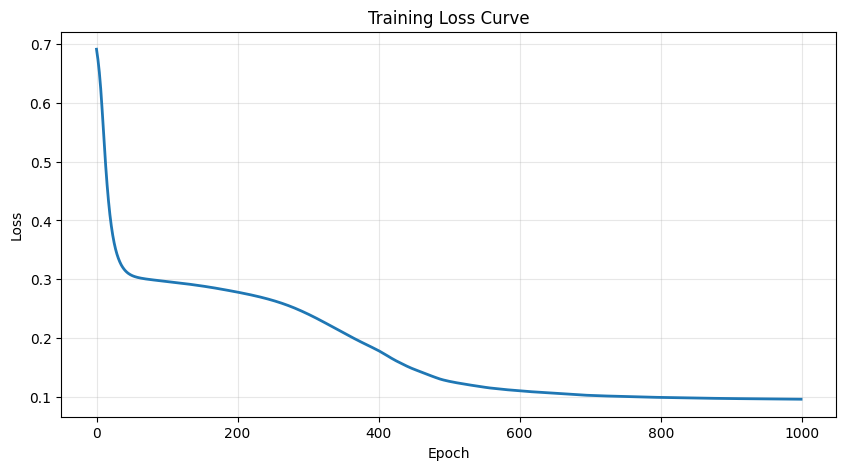

In [4]:

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=300, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def one_hot(y, n_classes=2):
    return np.eye(n_classes)[y]

y_train_oh = one_hot(y_train)
y_test_oh  = one_hot(y_test)

def _train_main_nn():
    net = TwoLayerNet(input_size=2, hidden_size=10, output_size=2, init_std=0.1)
    losses = []
    for epoch in range(1000):
        loss = net.train_step(X_train, y_train_oh, lr=0.5)
        losses.append(loss)
        if (epoch + 1) % 200 == 0:
            print(f"  Epoch {epoch+1}/1000, Loss: {loss:.4f}")
    y_pred_train = net.forward(X_train)
    y_pred_test  = net.forward(X_test)
    train_acc = np.mean(y_pred_train.argmax(axis=1) == y_train_oh.argmax(axis=1))
    test_acc  = np.mean(y_pred_test.argmax(axis=1)  == y_test_oh.argmax(axis=1))
    return net, losses, train_acc, test_acc

net, losses, train_acc, test_acc = cached("nn_training_main_lr0.5_1000epochs", _train_main_nn)
print(f"Final Training Accuracy: {train_acc*100:.2f}%")
print(f"Final Test Accuracy:     {test_acc*100:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(losses, linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Loss Curve')
plt.grid(alpha=0.3); plt.show()


## 3. Gradient Checking

Validate backprop implementation using numerical gradients.

In [5]:
def gradient_check(net, X, y, epsilon=1e-5):
    """
    Numerical gradient checking
    
    Compare analytic gradients from backprop to numerical gradients
    from finite differences
    """
    # Get analytic gradients
    y_pred = net.forward(X)
    grads_analytic = net.backward(y)
    
    # Check each parameter
    params = {'W1': net.W1, 'b1': net.b1, 'W2': net.W2, 'b2': net.b2}
    
    for param_name, param in params.items():
        grad_analytic = grads_analytic[f'd{param_name}']
        grad_numerical = np.zeros_like(param)
        
        # Compute numerical gradient for a subset of parameters
        it = np.nditer(param, flags=['multi_index'], op_flags=['readwrite'])
        count = 0
        while not it.finished and count < 10:  # Check only first 10 for speed
            ix = it.multi_index
            old_value = param[ix]
            
            # f(x + eps)
            param[ix] = old_value + epsilon
            y_plus = net.forward(X)
            loss_plus = net.compute_loss(y_plus, y)
            
            # f(x - eps)
            param[ix] = old_value - epsilon
            y_minus = net.forward(X)
            loss_minus = net.compute_loss(y_minus, y)
            
            # Numerical gradient
            grad_numerical[ix] = (loss_plus - loss_minus) / (2 * epsilon)
            
            # Restore
            param[ix] = old_value
            it.iternext()
            count += 1
        
        # Compare
        diff = np.linalg.norm(grad_analytic.ravel()[:10] - grad_numerical.ravel()[:10])
        rel_error = diff / (np.linalg.norm(grad_analytic.ravel()[:10]) + np.linalg.norm(grad_numerical.ravel()[:10]) + 1e-8)
        
        print(f"{param_name}: relative error = {rel_error:.2e}")
        if rel_error < 1e-5:
            print(f"  ✓ Gradient check passed!")
        elif rel_error < 1e-3:
            print(f"  ~ Gradient check OK (might be acceptable)")
        else:
            print(f"  ✗ Gradient check FAILED!")

# Run gradient check on small batch
print("Running gradient check...\n")
net_check = TwoLayerNet(input_size=2, hidden_size=5, output_size=2, init_std=0.1)
X_small = X_train[:10]
y_small = y_train_oh[:10]
gradient_check(net_check, X_small, y_small)

Running gradient check...

W1: relative error = 1.01e-08
  ✓ Gradient check passed!
b1: relative error = 9.99e-09
  ✓ Gradient check passed!
W2: relative error = 9.98e-09
  ✓ Gradient check passed!
b2: relative error = 9.95e-09
  ✓ Gradient check passed!


## 4. Initialization Experiments

Compare different initialization strategies: small random, Xavier/Glorot, He.

[cache] computing 'nn_init_comparison_500epochs'...
  small   : test acc=88.89%
  xavier  : test acc=98.89%
  he      : test acc=97.78%


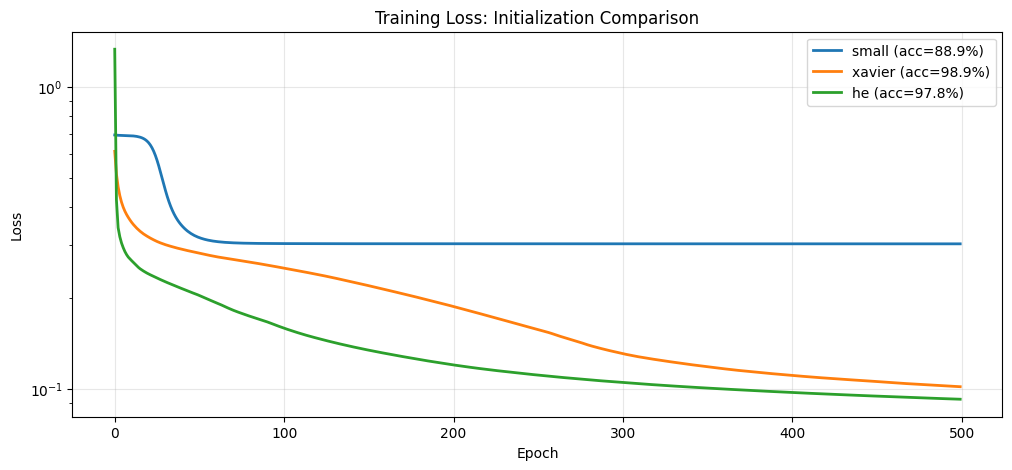

In [6]:

init_configs = {
    'small':  lambda: TwoLayerNet(2, 10, 2, init_std=0.01),
    'xavier': lambda: TwoLayerNet(2, 10, 2, init_std=np.sqrt(2.0 / (2 + 10))),
    'he':     lambda: TwoLayerNet(2, 10, 2, init_std=np.sqrt(2.0 / 2)),
}

def _run_init_experiments():
    results = {}
    for name, factory in init_configs.items():
        n = factory()
        losses = []
        for _ in range(500):
            losses.append(n.train_step(X_train, y_train_oh, lr=0.5))
        y_pred = n.forward(X_test)
        acc = np.mean(y_pred.argmax(axis=1) == y_test_oh.argmax(axis=1))
        results[name] = (losses, acc)
        print(f"  {name:8s}: test acc={acc*100:.2f}%")
    return results

init_results = cached("nn_init_comparison_500epochs", _run_init_experiments)

plt.figure(figsize=(12, 5))
for init_type, (losses, acc) in init_results.items():
    plt.plot(losses, label=f"{init_type} (acc={acc*100:.1f}%)", linewidth=2)
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training Loss: Initialization Comparison')
plt.legend(); plt.grid(alpha=0.3); plt.yscale('log'); plt.show()


## Exercises for Further Practice

1. **Add More Layers**: Extend the network to 3+ layers
2. **Different Activations**: Implement tanh, leaky ReLU, and compare
3. **Batch Processing**: Add mini-batch training support
4. **Regularization**: Add L2 regularization to the loss and gradients
5. **Visualization**: Plot decision boundaries for different network configurations

## Deliverables Checklist

- [ ] Fully connected neural network implementation from scratch
- [ ] Gradient checking validation
- [ ] Initialization experiments with analysis
- [ ] Training plots and performance metrics

## Recommended Resources

- CS231n lecture notes on backpropagation
- Andrew Ng's notes on neural networks
- "Neural Networks and Deep Learning" by Michael Nielsen (online book)

In [7]:

# EXERCISE 1 — 3-Layer Network
# Goal: extend TwoLayerNet to ThreeLayerNet by adding a second hidden layer.
# Train it on make_moons and compare decision boundaries to the 2-layer version.
# Use cached("nn_3layer_lr0.3_1000epochs", ...) to save training results.
# Expected insight: deeper networks can learn more complex boundaries,
# but also require careful initialization.


In [8]:

# EXERCISE 2 — tanh and Leaky ReLU Activations
# Goal: add tanh and leaky_relu (alpha=0.1) activation variants to TwoLayerNet.
# Train all three (sigmoid / tanh / leaky_relu) for 1000 epochs.
# Plot the loss curves and decision boundaries side by side.
# Use cached(f"nn_activation_{name}_1000epochs", ...) per activation.
# Expected insight: different activations converge at different speeds.


In [9]:

# EXERCISE 4 — L2 Regularization in Backprop
# Goal: add an L2 penalty λ||W||^2 to the loss.
# Derive and implement the gradient modification: dL/dW += 2λW.
# Train with λ in [0, 0.001, 0.01, 0.1] and plot test accuracy vs λ.
# Use cached(f"nn_l2_lambda_{lam}_500epochs", ...) per value.
# Expected insight: small λ helps generalization; too large and the model underfits.
